Our main goal is to be able to represent loaded music. We will use FFT for that.
What are the needs?
We're creating a video, let's say, 5 mins long, of 60fps. That means, we have 18.000 video frames in total.
If the incoming audio is of 44.100 sample rate, for each video frame we have 735 samples, so that would be our window for FFT analysis.

But, there's another thing to consider. The resulting texture.
Should it be updated each frame and contain only that window? Time consuming, we could fall off off being real time.
Or maybe we should prepare one texture of the whole song, where on Y axis it'd have FFT for a single frame, and frames would be put on X axis? Tat would be best, BUT - in case of our sampe 5mins long video it'd mean 18K length, that's not an option to load up as a texture into OpenGL...

First, let's see different options for signal analysis.

In [1]:
import numpy as np

sample_rate = 44100
frequency = 440
length = 1

t = np.linspace(0, length, sample_rate * length)
y = np.sin(frequency * 2 * np.pi * t)    
simple_sine_wave_440Hz = y

In [2]:
from scipy import signal

sampleRate = 44100
frequency_start = 1000
frequency_end = 8000
length = 1

t = np.linspace(0, length, sampleRate * length)
y = signal.chirp(t, f0=frequency_start, f1=frequency_end, t1=length)
m = np.max(np.abs(y))
maxint16 = np.iinfo(np.int16).max
y = maxint16 * y / m
y = y.astype(np.int16) 
freq_sweep_sine = y

In [3]:
sampleRate = 44100
ts = 1.0 / sample_rate
frequency_1 = 500
frequency_2 = 3000
frequency_3 = 6000
frequency_4 = 10000
length = 1

t = np.linspace(0, length, sample_rate * length)
y = np.sin(frequency_1 * 2 * np.pi * t)
y += np.sin(frequency_2 * 2 * np.pi * t)
y += np.sin(frequency_3 * 2 * np.pi * t)
y += np.sin(frequency_4 * 2 * np.pi * t)

multi_sine_4freqs = y

In [4]:
def get_audio_part(audio, time_start=0.0, sample_rate=44100, frame_rate=30, nframes = 1):
    samples_per_frame = int(sample_rate / frame_rate)
    sample_start = int(time_start * sample_rate)
    sample_end = sample_start + (nframes * samples_per_frame)
    N = sample_end - sample_start
    T = 1.0 / sample_rate
    t = np.linspace(0, nframes * (1.0 / frame_rate), int(sample_rate * nframes * (1.0 / frame_rate)))
    audio_part = audio[sample_start:sample_end]
    return (audio_part, N, T, t)

Simple FFT analysis

c:\Users\pito\.conda\envs\Python312PySide6\Lib\site-packages\matplotlib\cbook.py:1762: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
c:\Users\pito\.conda\envs\Python312PySide6\Lib\site-packages\matplotlib\cbook.py:1398: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


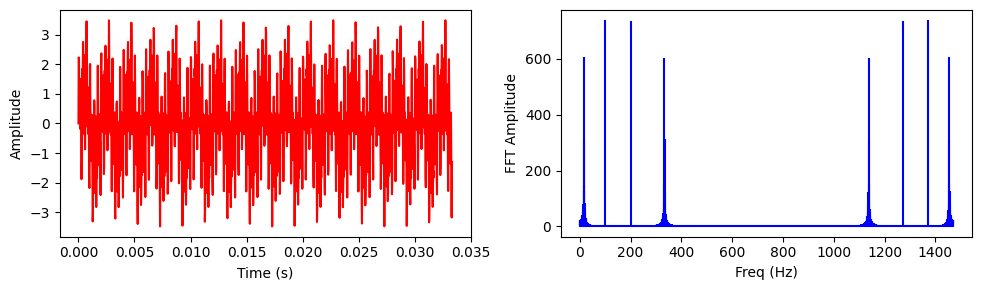

In [5]:
import matplotlib.pyplot as plt
from scipy.fftpack import fft, ifft

signal, N, T, t = get_audio_part(multi_sine_4freqs, time_start=0.0, sample_rate=44100, frame_rate=30, nframes=1)

signal_fft = fft(signal)
freq = t/T

plt.figure(figsize = (10, 3))

plt.subplot(121)
plt.plot(t, ifft(signal_fft), 'r')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')

plt.subplot(122)
plt.stem(freq, np.abs(signal_fft), 'b', markerfmt=" ", basefmt="-b")
plt.xlabel('Freq (Hz)')
plt.ylabel('FFT Amplitude')

plt.tight_layout()
plt.show()

Let's get rid of the mirrored imaginary part of FFT.

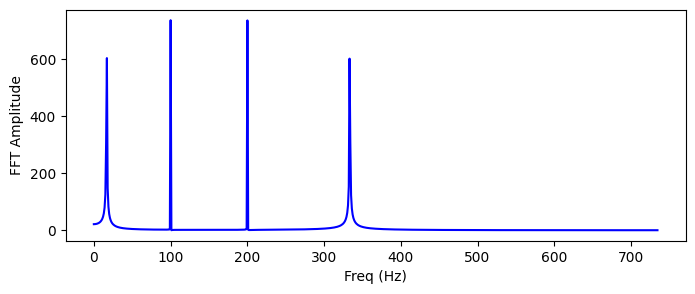

In [6]:
from scipy.fft import rfft

signal, N, T, t = get_audio_part(multi_sine_4freqs, time_start=0.0, sample_rate=44100, frame_rate=30, nframes=1)

signal_fft = rfft(signal)
freq = t/T

N_spectrum = int(N/2)
freqs_oneside = freq[0:N_spectrum]

plt.figure(figsize = (8, 3))
plt.plot(freqs_oneside, np.abs(signal_fft[:N_spectrum]), 'b')
plt.xlabel('Freq (Hz)')
plt.ylabel('FFT Amplitude')
plt.show()

Nest step is the implementation. The big thing is ShaderToy has its own, very specific, and maybe not the best way of implementing this. That means as a first step we will do it in compliance with ShaderTy, but once we implement another feature in the app, which is individual settings for each loaded texture, we could also add other implementations.

So, what exactly **ShaderToy** is saying about this texture?

It's a **512x2** bitmap. First row is frequencies amplitudes. It is containing 48kHz/4 (**12kHz**) in those 512 texels - on a **linear** Hz scale.
The second row of a texture is a sound wave.

In [8]:
from PIL import Image

def array_to_red_image(array) -> Image:
    """Makes an image from NDArray. Array values are transferred into R channel of RGB."""
    img = None
    # get absolute values
    array = abs(array)
    # get max value
    max = np.max(array)
    # normalize to 0.0 - 1.0 range
    arrayuint8 = array.astype(np.float64) / max
    # make it uint8 data
    arrayuint8 = 255 * arrayuint8
    # grey image from array
    img = Image.fromarray(arrayuint8.astype(np.uint8), mode='L')
    # empty grey image
    zero = np.zeros(array.shape, dtype=np.uint8)
    img_zero = Image.fromarray(zero, mode='L')
    # merge it. Real image goes to R channel, while G and B channels filled with zeroes
    img = Image.merge(mode='RGB', bands=(img, img_zero, img_zero))
    return img

In [9]:
def prepare_image(array, width, height):
    img = array_to_red_image(array)
    img = img.rotate(90, expand=True)
    img = img.resize((width, height))
    return img

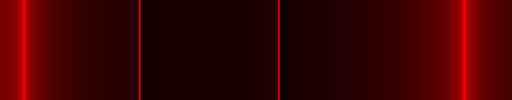

In [10]:
from scipy.signal.windows import hann
from scipy.fft import rfft

signal, N, T, t = get_audio_part(multi_sine_4freqs, time_start=0.0, sample_rate=44100, frame_rate=30, nframes=1)
signal_fft = rfft(signal)

# let's take only first half of freqs
N_spectrum = int(signal_fft.size/2)
spectrum = np.linspace(start=0.0, stop=(44100 / 4.0), num=N_spectrum)

for i in range(0, N_spectrum):
    magnitude = np.log10(np.abs(signal_fft[i]))
    spectrum[i] = magnitude

display(prepare_image(spectrum, 512, 100))

Let's collect both parts into one texture.

In [11]:
def merge_images(img1: Image, img2: Image):
    img = None
    final_width = np.max([img1.size[0], img2.size[0]])
    final_height = img1.size[1] + img2.size[1]
    img = Image.new('RGB', size=(final_width, final_height))
    img.paste(img1, (0, 0))
    img.paste(img2, (0, img1.size[1]))
    return img

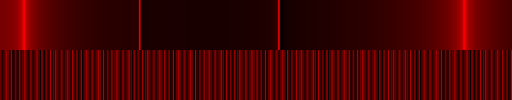

In [12]:
signal, N, T, t = get_audio_part(multi_sine_4freqs, time_start=0.0, sample_rate=44100, frame_rate=30, nframes=1)

wave_img = array_to_red_image(signal)
wave_img = wave_img.rotate(90, expand=True)
wave_img = wave_img.resize((512,50))

signal_fft = rfft(signal)
N_spectrum = int(signal_fft.size/2)
spectrum = np.linspace(start=0.0, stop=(44100 / 4.0), num=N_spectrum)
for i in range(0, N_spectrum):
    magnitude = np.log10(np.abs(signal_fft[i]))
    spectrum[i] = magnitude

spectrum_img = prepare_image(spectrum, 512, 50)
final_img_100px = merge_images(spectrum_img, wave_img)
display(final_img_100px)

Test on some real music:

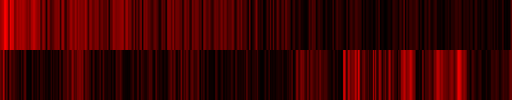

In [13]:
import librosa
audio, sample_rate = librosa.load('test_sound_01.mp3', mono=True, sr=44100)
signal, N, T, t = get_audio_part(audio, time_start=45.0, sample_rate=sample_rate, frame_rate=30, nframes=1)
wave_img_100px = prepare_image(signal, 512, 50)
wave_img_1px = prepare_image(signal, 512, 1)

signal_fft = rfft(signal)
N_spectrum = int(signal_fft.size/2)
spectrum = np.linspace(start=0.0, stop=(44100 / 4.0), num=N_spectrum)
for i in range(0, N_spectrum):
    magnitude = np.log10(np.abs(signal_fft[i]))
    spectrum[i] = magnitude
spectrum_img_100px = prepare_image(spectrum, 512, 50)
spectrum_img_1px = prepare_image(spectrum, 512, 1)

final_img_100px = merge_images(spectrum_img_100px, wave_img_100px)
final_img_1px = merge_images(spectrum_img_1px, wave_img_1px)
display(final_img_100px)
display(final_img_1px)

For reference, here's an official example shader from Inigo Quilez (https://iquilezles.org/)

```
void mainImage(out vec4 fragColor, in vec2 fragCoord)
{
	// create pixel coordinates
	vec2 uv = fragCoord.xy / iResolution.xy;

	// the sound texture is 512x2
	int tx = int(uv.x*512.0);

	// first row is frequency data (48Khz/4 in 512 texels, meaning 23 Hz per texel)
	float fft  = texelFetch(iChannel0, ivec2(tx,0), 0).x; 

	// second row is the sound wave, one texel is one mono sample
	float wave = texelFetch(iChannel0, ivec2(tx,1), 0).x;

	// convert frequency to colors
	vec3 col = vec3(fft, 4.0*fft*(1.0-fft), 1.0-fft) * fft;

	// add wave form on top	
	col += 1.0 -  smoothstep(0.0, 0.15, abs(wave - uv.y));

	// output final color
	fragColor = vec4(col,1.0);
}
```